In [13]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import beta as B
from scipy.special import betaln as lnB

In [14]:
data = np.loadtxt('binarydigits.txt')

Question 1

In [15]:
def learn_pML(data):
    N, D = data.shape
    pML = (1/N)*np.sum(data, axis=0)
    return pML

def learn_pMAP(data, alpha, beta):
    N, D = data.shape
    pML = learn_pML(data)
    pMAP = (pML + alpha - 1)/(alpha + beta - 1)
    return pMAP

def plot_pixels(data, title=''):
    plt.figure()
    plt.imshow(np.reshape(data, (8,8)), vmin=0, vmax=1, interpolation='None', cmap='grey')
    plt.title(title)


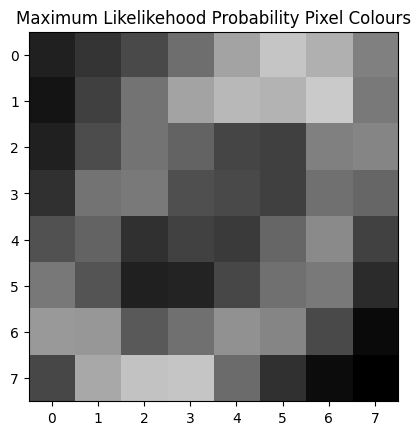

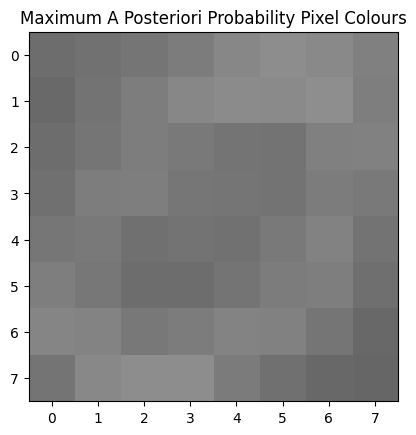

In [16]:
pML = learn_pML(data)
plot_pixels(pML, "Maximum Likelikehood Probability Pixel Colours")

pMAP = learn_pMAP(data, 3.0, 3.0)
plot_pixels(pMAP, "Maximum A Posteriori Probability Pixel Colours")

Question 2

In [17]:
N, D = map(int, data.shape)

alpha = 1 + np.sum(data)
beta = N*D + 1 - alpha
alpha_d = 1 + np.sum(data, axis=0)
beta_d = N - alpha_d

log_prob_model_a = N*D*np.log((0.5))
log_prob_model_b = lnB(alpha, beta)
log_prob_model_c = np.sum(lnB(alpha_d, beta_d))

avg_log_prob_model = np.mean([log_prob_model_a, log_prob_model_b, log_prob_model_c])

rel_prob_model_a = np.exp(log_prob_model_a - avg_log_prob_model)
rel_prob_model_b = np.exp(log_prob_model_b - avg_log_prob_model)
rel_prob_model_c = np.exp(log_prob_model_c - avg_log_prob_model)

# print('log_prob_model_a : log_prob_model_b : log_prob_model_c = ', log_prob_model_a, ':', log_prob_model_b, ':', log_prob_model_c)

print('(relative) prob_model_a : prob_model_b : prob_model_c = ', rel_prob_model_a, ':', rel_prob_model_b, ':', rel_prob_model_c)

(relative) prob_model_a : prob_model_b : prob_model_c =  3.79475594665626e-118 : 9.755326203651874e-52 : 2.701309548088313e+168


Question 3

In [36]:
from scipy.special import logsumexp

EPS = 1e-9

def clip_probabilities(p, eps=EPS):
    return np.clip(p, eps, 1.0 - eps)


def param_init(K, X, rng=None):
    """Randomly initialize mixture weights and Bernoulli parameters."""
    if rng is None:
        rng = np.random.default_rng()
    _, D = X.shape
    pi = rng.dirichlet(np.ones(K))
    P = rng.uniform(0.25, 0.75, size=(K, D))
    return pi, P


def update_log_r_nk(pi_k, P_k, X_n):
    pi_k = np.clip(pi_k, EPS, 1.0)
    P_k = clip_probabilities(P_k)
    log_pi_k = np.log(pi_k)
    log_P_k = np.log(P_k)
    log_one_minus_P_k = np.log(1.0 - P_k)
    log_prob = log_pi_k + np.dot(X_n, log_P_k) + np.dot(1.0 - X_n, log_one_minus_P_k)
    return log_prob


def update_P_d(r_nk, X_d):
    weighted_sum = r_nk.T @ X_d
    responsibility_sum = np.clip(r_nk.sum(axis=0), EPS, None)
    P_d_new = weighted_sum / responsibility_sum
    return clip_probabilities(P_d_new)


def update_pi(r, X=None):
    pi_new = r.sum(axis=0)
    pi_new = np.clip(pi_new, EPS, None)
    pi_new /= pi_new.sum()
    return pi_new


def e_step(pi, P, X):
    N, _ = X.shape
    K, _ = P.shape
    log_r = np.zeros((N, K))
    log_likelihood = 0.0
    for n in range(N):
        row_logs = np.array([update_log_r_nk(pi[k], P[k], X[n]) for k in range(K)])
        row_norm = logsumexp(row_logs)
        log_likelihood += row_norm
        log_r[n] = row_logs - row_norm
    r_new = np.exp(log_r)
    return r_new, log_likelihood


def m_step(r, X):
    pi_new = update_pi(r)
    _, D = X.shape
    K = r.shape[1]
    P_new = np.zeros((K, D))
    for d in range(D):
        P_new[:, d] = update_P_d(r, X[:, d])
    return pi_new, P_new


def em_run(K, X, max_iter=1000, tol=1e-6):
    pi, P = param_init(K, X)
    log_likelihood_history = []
    prev_log_likelihood = -np.inf
    for iteration in range(max_iter):
        r, log_likelihood = e_step(pi, P, X)
        pi, P = m_step(r, X)
        log_likelihood_history.append(log_likelihood)
        if np.abs(log_likelihood - prev_log_likelihood) < tol:
            break
        prev_log_likelihood = log_likelihood
    return pi, P, log_likelihood_history


In [37]:
pi, P, log_history = em_run(2, data)
print(f'Final log likelihood: {log_history[-1]:.3f}')
print('Mixture weights:', pi)


TypeError: only integer scalar arrays can be converted to a scalar index